# Robust Regression and Hamiltonian Monte Carlo

**STATS271/371: Applied Bayesian Statistics** <br>
_Scott Linderman_ <br>
_Stanford University. Winter, 2021._

---

Demo notebook to go along with "Lap 3" lectures.

In [19]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats as ss
import autograd.scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logsumexp
from scipy.stats import bernoulli
from tqdm.auto import trange
# from google.colab import files
sns.set_context("notebook")

## Simulate random data

In [2]:
# Sample random covariates and data
N = 50                      # number of datapoints
P = 1                       # polynomial degree
rng = npr.RandomState(0)
us = rng.normal(size=(N,))
xs = np.column_stack([
    us**p for p in range(P+1)
])

# Sample data
true_w = np.array([-1.0, 1.0])
true_sigmasq = 0.25**2
ys = rng.normal(xs @ true_w, np.sqrt(true_sigmasq))

# Replace a fraction data with outliers
outliers = rng.rand(N) < 0.2
ys[outliers] = rng.normal(size=sum(outliers))

## Plot the data

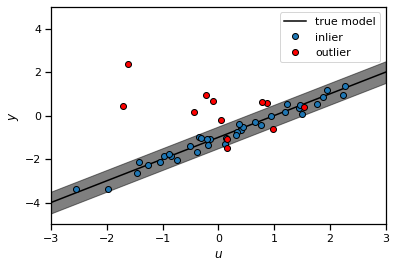

In [3]:
us_grid = np.linspace(-3, 3)
xs_grid = np.column_stack([
    us_grid**p for p in range(P+1)
])

true_mean = xs_grid @ true_w
plt.plot(us_grid, true_mean, '-k', label="true model")
plt.fill_between(us_grid,
                 true_mean - 2 * np.sqrt(true_sigmasq),
                 true_mean + 2 * np.sqrt(true_sigmasq),
                 color='k', alpha=0.5
                 )
plt.plot(us[~outliers], ys[~outliers], 'o', mec='k', label="inlier")
plt.plot(us[outliers], ys[outliers], 'o', mec='k', mfc='r', label="outlier")
plt.xlim(-3, 3)
plt.xlabel("$u$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.legend()
plt.savefig("lap3/data.pdf")
# files.download('data.pdf') 

## Compute the posterior under the regular regression model

In [4]:
def compute_suff_stats(ys, xs):
    N = len(ys)
    assert xs.shape[0] == N

    ysq = np.einsum('n,n->', ys, ys)
    yx = np.einsum('n,ni->i', ys, xs)
    xxT = np.einsum('ni,nj->ij', xs, xs)
    return N, ysq, yx, xxT

# Write functions to convert between "mean" # and "natural" parameters of the 
# prior. The natural parameters are pseudo statistics of the posterior.
def prior_mean_to_natural(nu, tausq, mu, Lambda):
    pseudo_N = nu
    pseudo_ysq = nu * tausq + mu @ Lambda @ mu
    pseudo_yx = Lambda @ mu
    pseudo_xxT = Lambda
    return pseudo_N, pseudo_ysq, pseudo_yx, pseudo_xxT

def prior_natural_to_mean(N, ysq, yx, xxT):
    nu = N
    Lambda = xxT
    mu = np.linalg.solve(Lambda, yx)
    tausq = (ysq - mu @ Lambda @ mu) / nu
    return nu, tausq, mu, Lambda

# Initialize the prior statistics to all zeros
prior_stats = (0, 0, 0, 0)

# Compute posterior parameters directly
sum_tuples = lambda a, b: tuple(ai + bi for ai, bi in zip(a, b))
posterior_stats = sum_tuples(prior_stats, compute_suff_stats(ys, xs))
nu_post, tausq_post, mu_post, Lambda_post = prior_natural_to_mean(*posterior_stats)



## Plot the posterior of the variance


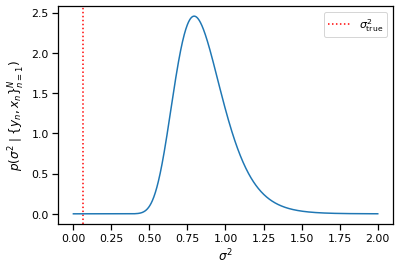

In [5]:
# Convert to inverse gamma parameters
from scipy.stats import invgamma
sigmasq_grid = np.linspace(1e-3, 2.0, 1000)

alpha_post = nu_post / 2
beta_post = nu_post * tausq_post / 2
plt.plot(sigmasq_grid, invgamma(alpha_post, scale=beta_post).pdf(sigmasq_grid))

# Plot the true value of sigmasq
yl = plt.ylim()
plt.vlines(true_sigmasq, *yl, colors='r', linestyles=':', label="$\sigma^2_{\mathsf{true}}$")

plt.xlabel("$\sigma^2$")
plt.ylabel("$p(\sigma^2 \mid \{y_n, x_n\}_{n=1}^N)$")
plt.ylim(yl)
plt.legend()

plt.savefig("lap3/sigmasq_post.pdf")

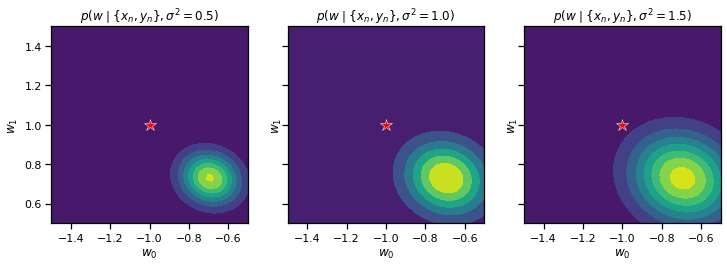

In [6]:
# Make a 2D gride of weights
from scipy.stats import multivariate_normal

n_pts = 50
W0, W1 = np.meshgrid(np.linspace(-1.5, -0.5, n_pts),
                     np.linspace( 0.5,  1.5, n_pts))
w_grid = np.column_stack([W0.ravel(), W1.ravel()])

# Plot the weight posterior for a few values of sigma
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, sigmasq in zip(axs, [0.5, 1.0, 1.5]):
    Sigma_post = sigmasq * np.linalg.inv(Lambda_post)
    p_w_post = multivariate_normal.pdf(w_grid, mu_post, Sigma_post)
    ax.contourf(W0, W1, p_w_post.reshape(n_pts, n_pts))
    ax.plot(true_w[0], true_w[1], 'r*', mec='w', mew=0.5, ms=12)
    ax.set_aspect("equal")
    ax.set_ylabel("$w_1$")
    ax.set_xlabel("$w_0$")
    ax.set_title("$p(w \mid \{{x_n, y_n\}}, \sigma^2={:.1f})$".format(sigmasq))

plt.savefig("lap3/w_post.pdf")

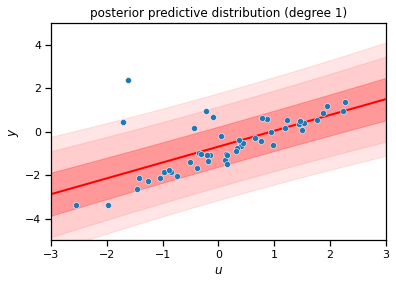

In [7]:
# Plot posterior predictive distribution p(y | x, \{x_n, y_n\}) at a grid of x's
from scipy.stats import t as studentst
loc_pred = xs_grid @ mu_post
tmp = np.sum(xs_grid * np.linalg.solve(Lambda_post, xs_grid.T).T, axis=1)
scale_pred = np.sqrt(tausq_post * (1 + tmp))
post_pred = studentst(nu_post, loc=loc_pred, scale=scale_pred)

# plt.fill_between(us_grid,
#                  post_pred.mean() - 2 * post_pred.std(),
#                  post_pred.mean() + 2 * post_pred.std(), 
#                  color='r', alpha=0.5
#                  )
# plt.plot(us_grid, post_pred.mean(), '-r', lw=2)

plt.plot(us_grid, post_pred.mean(), '-r', lw=2, label="estimated model")
plt.fill_between(us_grid,
                 post_pred.ppf(0.005),
                 post_pred.ppf(0.995),
                 color='r', alpha=0.1
                 )

plt.fill_between(us_grid,
                 post_pred.ppf(0.025),
                 post_pred.ppf(0.975),
                 color='r', alpha=0.1
                 )

plt.fill_between(us_grid,
                 post_pred.ppf(0.16),
                 post_pred.ppf(0.84),
                 color='r', alpha=0.25
                 )

plt.plot(us, ys, 'o', mec='w', mew=0.5)
plt.xlabel("$u$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.xlim(us_grid[0], us_grid[-1])
plt.title("posterior predictive distribution (degree {})".format(P))

plt.savefig("lap3/post_pred.pdf")
# files.download('post_pred_{}.pdf'.format(P-1)) 

# Robust model with Student's t noise

Consider the following _robust regression_ model instead,
\begin{align}
y_n &\sim t(w^\top x_n, \sigma^2, \nu),
\end{align}
where $t(\mu, \sigma^2, \nu)$ denotes the Student's t distribution with mean $\mu$, scale $\sigma$, and $\nu$ degrees of freedom. The $t$ distribution has heavier tails than the Gaussian distribution with the same mean and scale, as shown below.

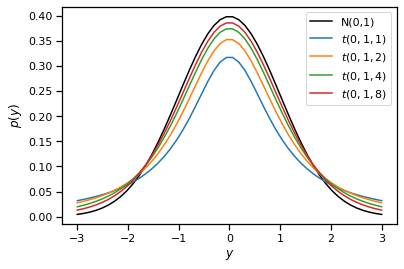

In [8]:
y_grid = np.linspace(-3, 3)
nus = [1, 2, 4, 8]
plt.plot(y_grid, ss.norm.pdf(y_grid, 0, 1), '-k', label="N(0,1)")
for nu in nus:
    plt.plot(y_grid, ss.t.pdf(y_grid, nu, 0, 1), 
             label="$t(0, 1, {:d})$".format(nu))
    
plt.legend()
plt.xlabel("$y$")
plt.ylabel("$p(y)$")

plt.savefig("lap3/t_pdf.pdf")

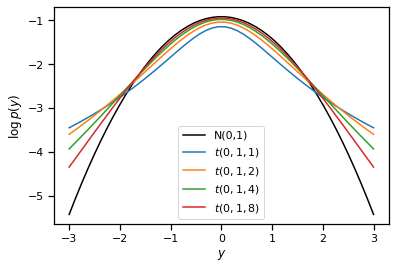

In [9]:
y_grid = np.linspace(-3, 3)
nus = [1, 2, 4, 8]
plt.plot(y_grid, ss.norm.logpdf(y_grid, 0, 1), '-k', label="N(0,1)")
for nu in nus:
    plt.plot(y_grid, ss.t.logpdf(y_grid, nu, 0, 1), 
             label="$t(0, 1, {:d})$".format(nu))
    
plt.legend()
plt.xlabel("$y$")
plt.ylabel("$\log \, p(y)$")

plt.savefig("lap3/t_logpdf.pdf")

## Define log probability under an uninformative prior


In [10]:
def log_probability(w, log_tausq, log_nu):
    """Evaluate the log probability of the data above
    under a Student's t regression model with:
    
    w: weights
    log_tausq: log of the non-negative variance
    log_nu: log of the degree of freedom
    """
    # likelihood
    lp = ss.t.logpdf(ys, np.exp(log_nu), xs @ w, np.sqrt(np.exp(log_tausq))).sum()
    
    # prior: Gaussian on log(sigmasq) and log(nu)
    lp += ss.norm.logpdf(log_tausq, 0, 2.0)
    lp += ss.norm.logpdf(log_nu, 0, 2.0)
    
    return lp

## Plot the contours of the log joint for various parameter values

-106.43466041490282 -42.48215995701189
-123.1144235985475 -44.04702913066364
-158.10215860114857 -55.15070816220534
-91.14240748415516 -53.587461460853824
-90.87150154143771 -50.31284687284857
-97.69267289339645 -52.209100190642495
-92.30224365174321 -74.10881457064164
-86.1786722830961 -69.01250746282399
-84.14232481094234 -67.21428335093921


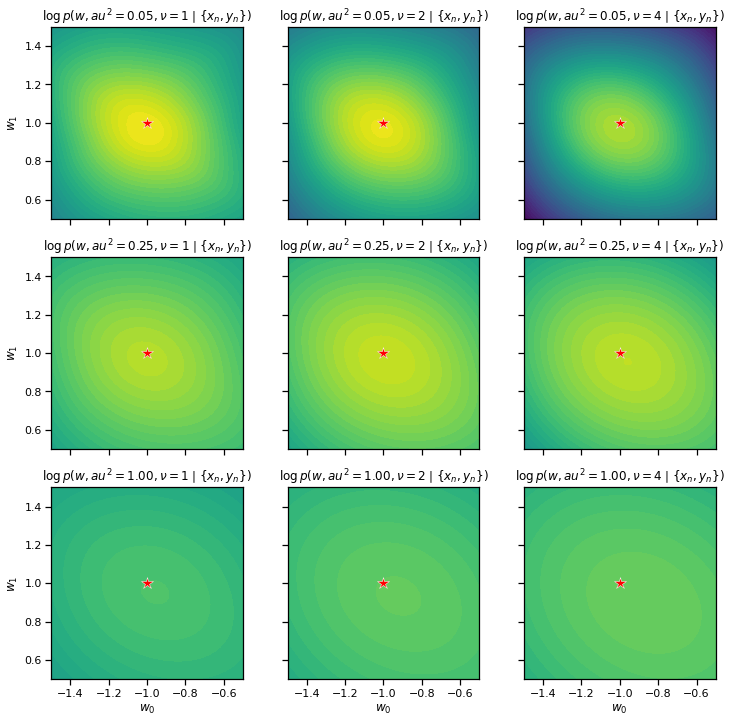

In [11]:
# Make a 2D gride of weights
n_pts = 50
W0, W1 = np.meshgrid(np.linspace(-1.5, -0.5, n_pts),
                     np.linspace( 0.5,  1.5, n_pts))
w_grid = np.column_stack([W0.ravel(), W1.ravel()])

tausqs = [0.05, 0.25, 1.0]
nus = [1.0, 2.0, 4.0]

# Plot the weight posterior for a few values of sigma
fig, axs = plt.subplots(len(tausqs), len(nus), 
                        figsize=(4 * len(nus), 4 * len(tausqs)), 
                        sharex=True, sharey=True)

# specify contour range (based on printing the max in each plot)
contours = np.linspace(-160, -40, 50)

for i, tausq in enumerate(tausqs):
    for j, nu in enumerate(nus):
        ax = axs[i, j]
        
        lp_ij = np.array([log_probability(w, np.log(tausq), np.log(nu)) for w in w_grid])
        print(lp_ij.min(), lp_ij.max())
        ax.contourf(W0, W1, lp_ij.reshape(n_pts, n_pts), contours)
        ax.plot(true_w[0], true_w[1], 'r*', mec='w', mew=0.5, ms=12)
        ax.set_aspect("equal")
        if j == 0:
            ax.set_ylabel("$w_1$")
        if i == len(tausqs) - 1:
            ax.set_xlabel("$w_0$")
        ax.set_title("$\log \, p(w, \tau^2={:.2f}, \\nu={:.0f} \mid \{{x_n, y_n\}})$".format(tausq, nu))

plt.savefig("lap3/robust_w_post.pdf")
# files.download('w_post.pdf') 

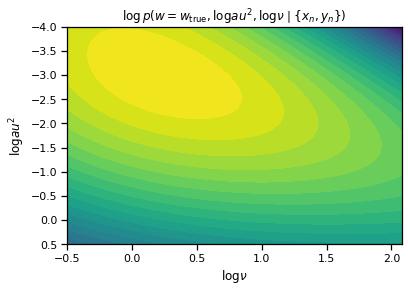

In [12]:
# plt.ylim(1.25, 0.0)
n_pts = 50
LOG_NU, LOG_TAUSQ = np.meshgrid(np.linspace(-0.5, np.log(8), n_pts),
                                  np.linspace(-4,  0.5, n_pts))
nt_grid = np.column_stack([LOG_NU.ravel(), LOG_TAUSQ.ravel()])

lp = np.array([log_probability(true_w, log_tausq, log_nu) 
               for (log_nu, log_tausq) in nt_grid])
plt.contourf(LOG_NU, LOG_TAUSQ, lp.reshape(n_pts, n_pts), 25)
plt.ylabel("$\log \tau^2$")
plt.ylim(0.5, -4)
plt.xlabel("$\log \\nu$")
plt.title("$\log \, p(w=w_{\mathsf{true}}, \log \tau^2, \log \\nu \mid \{{x_n, y_n\}})$")

plt.savefig("lap3/robust_post.pdf")

## Find the posterior mode

In [13]:
from autograd import grad
from autograd.misc import flatten
from scipy.optimize import minimize

# Optimize over the space of (w, log(sigmasq), log(nu)),
# which is uncontrained. Use `flatten` to go back and forth
# between a vector and a tuple of parameters. Initialize the
# parameters to all zeros.
init_params, unflatten = flatten((np.zeros_like(true_w), 0.0, 0.0))

# Minimize the average negative log probability 
# over the unconstrained space
def objective(params):
    w, log_tausq, log_nu = unflatten(params)
    return -log_probability(w, log_tausq, log_nu) / N

# Keep track of the params visited during optimization.
param_hist = [init_params]
def callback(params):
    param_hist.append(params)


# Run the optimizer
result = minimize(objective, 
                  init_params,
                  jac=grad(objective),
                  callback=callback)

# Extract the MAP estimate
w_map, log_tausq_map, log_nu_map = unflatten(result.x)
tausq_map = np.exp(log_tausq_map)
nu_map = np.exp(log_nu_map)

# Unpack the parameter history
param_hist = np.array(param_hist)
w_hist = param_hist[:, :-2]
log_tausq_hist = param_hist[:, -2]
log_nu_hist = param_hist[:, -1]

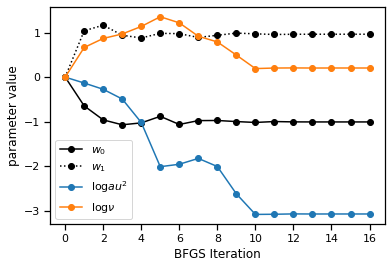

In [14]:
plt.plot(w_hist[:, 0], '-ko', label="$w_0$")
plt.plot(w_hist[:, 1], ':ko', label="$w_1$")
plt.plot(log_tausq_hist, '-o', label="$\log \tau^2$")
plt.plot(log_nu_hist, '-o', label="$\log \\nu$")

plt.legend()
plt.xlabel("BFGS Iteration")
plt.ylabel("parameter value")

plt.savefig("lap3/bfgs.pdf")

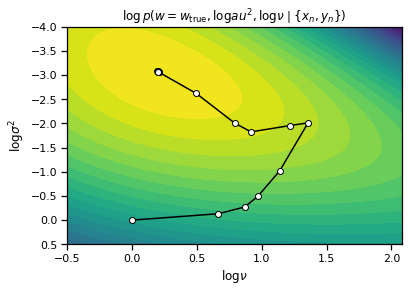

In [15]:
# plt.ylim(1.25, 0.0)
n_pts = 50
LOG_NU, LOG_TAUSQ = np.meshgrid(np.linspace(-0.5, np.log(8), n_pts),
                                  np.linspace(-4,  0.5, n_pts))
nt_grid = np.column_stack([LOG_NU.ravel(), LOG_TAUSQ.ravel()])

lp = np.array([log_probability(true_w, log_tausq, log_nu) 
               for (log_nu, log_tausq) in nt_grid])
plt.contourf(LOG_NU, LOG_TAUSQ, lp.reshape(n_pts, n_pts), 25)
plt.plot(log_nu_hist, log_tausq_hist, '-ko', mec='k', mfc='w')
plt.ylabel("$\log \sigma^2$")
plt.ylim(0.5, -4)
plt.xlabel("$\log \\nu$")
plt.title("$\log \, p(w=w_{\mathsf{true}}, \log \tau^2, \log \\nu \mid \{{x_n, y_n\}})$")

plt.savefig("lap3/robust_post2.pdf")



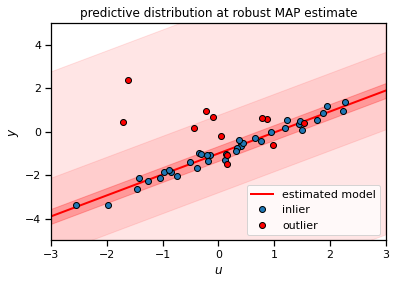

In [16]:
# Plot the estimated model with the most likely per-datapoint variance
from scipy.stats import t as studentst

us_grid = np.linspace(-3, 3)
xs_grid = np.column_stack([
    us_grid**p for p in range(P+1)
])

est_mean = xs_grid @ w_map

post_pred = studentst(nu_map, est_mean, np.sqrt(tausq_map))

plt.plot(us_grid, post_pred.mean(), '-r', lw=2, label="estimated model")
plt.fill_between(us_grid,
                 post_pred.ppf(0.005),
                 post_pred.ppf(0.995),
                 color='r', alpha=0.1
                 )

plt.fill_between(us_grid,
                 post_pred.ppf(0.025),
                 post_pred.ppf(0.975),
                 color='r', alpha=0.1
                 )

plt.fill_between(us_grid,
                 post_pred.ppf(0.16),
                 post_pred.ppf(0.84),
                 color='r', alpha=0.25
                 )

plt.plot(us[~outliers], ys[~outliers], 'o', mec='k', label="inlier")
plt.plot(us[outliers], ys[outliers], 'o', mec='k', mfc='r', label="outlier")
plt.xlim(-3, 3)
plt.xlabel("$u$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.legend(loc="lower right")
plt.title("predictive distribution at robust MAP estimate")

plt.savefig("lap3/robust_map_pred.pdf")
# files.download('data.pdf') 

# Metropolis Hastings

In [115]:
def mh(log_joint, init_theta, 
       n_samples=10000,
       stepsize=0.1,
       **kwargs):
    """Perform MH on the given log joint. Start at the given initial parameters
    and run the specified number of samples.
    
    log_joint: a function mapping theta, **kwargs -> R to compute the log joint.
        assume theta is unconstrained. Any keyword args to hmc are passed to this
        function.
    """
    assert init_theta.ndim == 1
    dim = len(init_theta)
    zeros = np.zeros(dim)
        
    # Initialize the samples
    samples = np.zeros((n_samples, dim))
    samples[0]  = init_theta

    # Run the sampler
    for i in trange(1, n_samples):
        # Make a random proposal
        theta_curr = samples[i-1]
        prop_step = stepsize * npr.randn(dim) 
        theta_prop = theta_curr + prop_step
        
        # Accept/reject step       
        dpotential = log_joint(theta_prop, **kwargs) - log_joint(theta_curr, **kwargs)
        accept = np.log(npr.rand()) < dpotential
        samples[i] = theta_prop if accept else samples[i-1]
        
    return samples

In [128]:
init_params, unflatten = flatten((np.zeros_like(true_w), 0.0, 0.0))

# Minimize the average negative log probability 
# over the unconstrained space
def _log_joint(params):
    w, log_tausq, log_nu = unflatten(params)
    return log_probability(w, log_tausq, log_nu)

# Run the optimizer
n_samples = 100000
samples = mh(_log_joint, init_params, n_samples=n_samples, stepsize=0.1)

# Unpack the parameter history
w_samples = samples[:, :-2]
log_tausq_samples = samples[:, -2]
log_nu_samples = samples[:, -1]

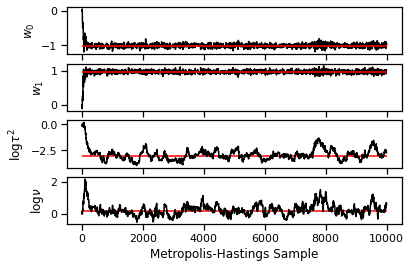

In [134]:
slc = slice(0, 10000)

fig, axs = plt.subplots(4, 1, sharex=True)
axs[0].plot(w_samples[slc, 0], '-k')
axs[0].hlines(w_map[0], slc.start, slc.stop, colors='r',zorder=3)
axs[0].set_ylabel("$w_0$")

axs[1].plot(w_samples[slc, 1], '-k')
axs[1].hlines(w_map[1], slc.start, slc.stop, colors='r', zorder=3)
axs[1].set_ylabel("$w_1$")

axs[2].plot(log_tausq_samples[slc], '-k')
axs[2].set_ylabel("$\log \\tau^2$")
axs[2].hlines(log_tausq_map, slc.start, slc.stop, colors='r')

axs[3].plot(log_nu_samples[slc], '-k')
axs[3].set_ylabel("$\log \\nu$")
axs[3].hlines(log_nu_map, slc.start, slc.stop, colors='r')

plt.xlabel("Metropolis-Hastings Sample")
plt.savefig("lap3/mh_traces.pdf")

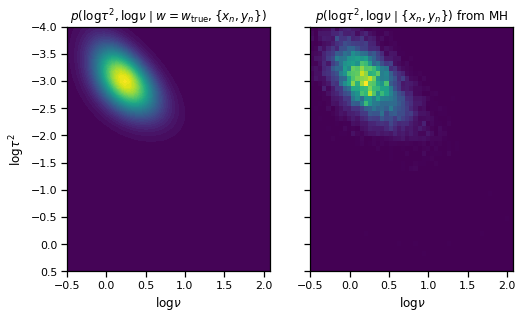

In [135]:
# plt.ylim(1.25, 0.0)
n_pts = 50
LOG_NU, LOG_TAUSQ = np.meshgrid(np.linspace(-0.5, np.log(8), n_pts),
                                np.linspace(-4,  0.5, n_pts))
nt_grid = np.column_stack([LOG_NU.ravel(), LOG_TAUSQ.ravel()])
lp = np.array([log_probability(true_w, log_tausq, log_nu) 
               for (log_nu, log_tausq) in nt_grid])


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4.5))
axs[0].contourf(LOG_NU, LOG_TAUSQ, np.exp(lp).reshape(n_pts, n_pts), 50)
axs[0].set_ylabel("$\log \\tau^2$")
axs[0].set_ylim(0.5, -4)
axs[0].set_xlabel("$\log \\nu$")
axs[0].set_title("$p(\log \\tau^2, \log \\nu \mid w=w_{\mathsf{true}}, \{{x_n, y_n\}})$")

axs[1].hist2d(log_nu_samples,
              log_tausq_samples,
              [np.linspace(-0.5, np.log(8), 50),
               np.linspace(-4,  0.5, 50)])
axs[1].set_ylim(0.5, -4)
axs[1].set_xlabel("$\log \\nu$")
axs[1].set_title("$p(\log \\tau^2, \log \\nu \mid \{{x_n, y_n\}})$ from MH")

# plt.savefig("lap3/robust_post2.pdf")
plt.savefig("lap3/mh_nu_tausq_density.pdf")


## Autocorrelation function

In [136]:
import tensorflow_probability as tfp

acfs = [tfp.stats.auto_correlation(samples[:, i], max_lags=1000) for i in range(4)]

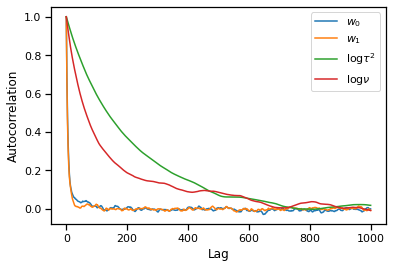

In [137]:
plt.plot(acfs[0], label="$w_0$")
plt.plot(acfs[1], label="$w_1$")
plt.plot(acfs[2], label="$\log \\tau^2$")
plt.plot(acfs[3], label="$\log \\nu$")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.savefig("lap3/mh_autocorr.pdf")


In [133]:
tfp.mcmc.effective_sample_size(samples)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([5629.60442571, 7235.44638914,  257.21227007,  364.43630543])>